In [1]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/TrainrBergomiTermStructure.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:11]
yy=dat[:,11:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

print(xx.shape)
print(yy.shape)

(80000, 11)
(80000, 88)


In [2]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
scale_x = StandardScaler()
scale_y=  StandardScaler()

def xtransform(x_train, x_test):
    return [scale_x.fit_transform(x_train),scale_x.transform(x_test)]

def xinversetransform(x):
    return scale_x.inverse_transform(x)

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,4,0,0.5])
lb=np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.5,-1,0.025])
def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device is {device}")

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_transform).to(device=device),
                                               torch.from_numpy(y_train_transform).to(device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_transform).to(device=device),
                                              torch.from_numpy(y_test_transform).to(device=device))


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

data_loader = torch.utils.data.DataLoader(train_dataset,batch_size =64,shuffle=True)

device is cuda


In [3]:
import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparas = {'input_dim':11,'hidden_dim':64,'hidden_nums':10,'output_dim':88,'block_layer_nums':3}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=torch.float64)

loss_MSE = nn.MSELoss()
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.0001)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 6.475301749413117
test loss is 6.2329485580524375
Batch: 100,train loss is: 1.0238066282247584
test loss is 1.0253335103341257
Batch: 200,train loss is: 0.6803105211134238
test loss is 0.6990184799930169
Batch: 300,train loss is: 0.432935494278918
test loss is 0.4914489925873697
Batch: 400,train loss is: 0.3432318415722258
test loss is 0.36324167022059567
Batch: 500,train loss is: 0.2863188083305255
test loss is 0.27403229228741244
Batch: 600,train loss is: 0.21252599203666342
test loss is 0.21202321346775876
Batch: 700,train loss is: 0.1949674306981533
test loss is 0.17254985909969398
Batch: 800,train loss is: 0.12763863447097787
test loss is 0.14118516936941153
Batch: 900,train loss is: 0.1196605619560349
test loss is 0.12110492999769795
Batch: 1000,train loss is: 0.10734508108384348
test loss is 0.10477027338696843
-----------------------Epoch: 1----------------------------------
Batch: 0,train

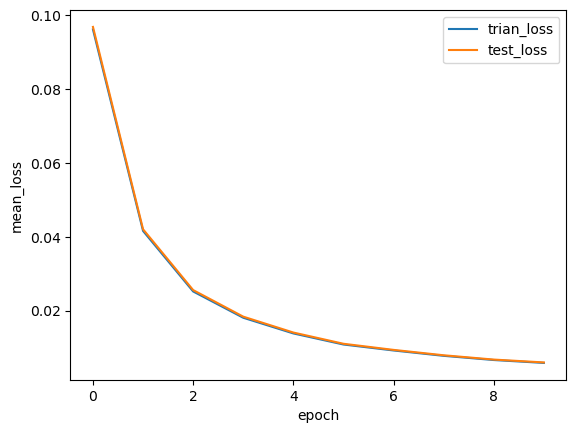

In [4]:
from torch_NN.train import train_model

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,10)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.006445599956755495
test loss is 0.005896882953534683
Batch: 100,train loss is: 0.005207272767602983
test loss is 0.005763928501719435
Batch: 200,train loss is: 0.006190131820958718
test loss is 0.0056788452615917
Batch: 300,train loss is: 0.00597163908069144
test loss is 0.005632872745455216
Batch: 400,train loss is: 0.006157000636042126
test loss is 0.005671585115315676
Batch: 500,train loss is: 0.005417835419302392
test loss is 0.005649640835327939
Batch: 600,train loss is: 0.005432553504643715
test loss is 0.005607454242884531
Batch: 700,train loss is: 0.005208587933006991
test loss is 0.005620534377302732
Batch: 800,train loss is: 0.005040520943881561
test loss is 0.005593424109291184
Batch: 900,train loss is: 0.005448849272817508
test loss is 0.005586707076838433
Batch: 1000,train loss is: 0.005135691279793872
test loss is 0.005621552324181783
-----------------------Epoch: 1----------------

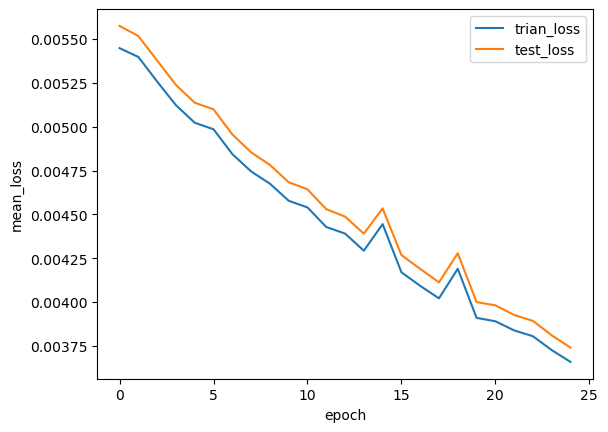

In [5]:
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.00001)

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,25)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.004455483116923966
test loss is 0.003738602951434161
Batch: 100,train loss is: 0.0031892592235375533
test loss is 0.003752138418092269
Batch: 200,train loss is: 0.003254877440182824
test loss is 0.003765156144921112
Batch: 300,train loss is: 0.004343042528472691
test loss is 0.0037405136805801773
Batch: 400,train loss is: 0.003717349887281521
test loss is 0.0038259088618264707
Batch: 500,train loss is: 0.00350359774196077
test loss is 0.003737707216469984
Batch: 600,train loss is: 0.003948179505476668
test loss is 0.0037709933143772875
Batch: 700,train loss is: 0.004391952096797586
test loss is 0.0037319728389331496
Batch: 800,train loss is: 0.0038693767387065533
test loss is 0.0038281665440108113
Batch: 900,train loss is: 0.0033840862283737432
test loss is 0.0037117228601187893
Batch: 1000,train loss is: 0.003285859689064137
test loss is 0.003735403808077059
-----------------------Epoch: 1-----

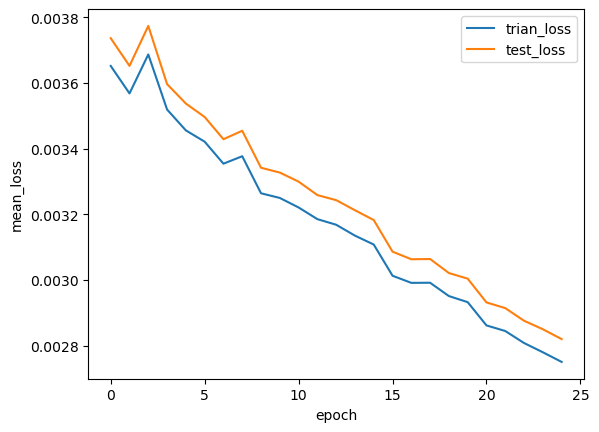

In [6]:
train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,25)

In [7]:
torch.save(model.state_dict(),'../../Data/YU/rpiecewiseBergomi.pth')